In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [89]:
# Import libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import gc




# Load data

In [4]:
train_df = pd.read_csv('../input/aryaai-dataset/Arya_DataScientist_Assignment/training_set.csv')
test_df = pd.read_csv('../input/aryaai-dataset/Arya_DataScientist_Assignment/test_set.csv')

# Explore data

In [5]:
train_df.head(5)

In [6]:
train_df.describe()

In [7]:
print("Columns: \n{0} ".format(train_df.columns.tolist()))

In [8]:
train_df.info()

## Missing values

In [9]:
mv = train_df.isna().any()
print(mv[mv == True])

# No missing values

## Duplicate data

In [10]:
train_df.duplicated().sum()

In [11]:
# Null values 
train_df.isnull().sum().max()

In [12]:
train_df['Y'].value_counts()

In [13]:
print('Class 0',round(train_df['Y'].value_counts()[0]/len(train_df)*100,2))
print('Class 1',round(train_df['Y'].value_counts()[1]/len(train_df)*100,2))

Majority of records are class 0 type.  

In [14]:
sns.color_palette("Paired")

sns.countplot('Y',data = train_df)
plt.title('Class Distributions \n',fontsize=14)

# Visualizations

In [15]:
train_df.hist(bins=10,figsize=(15,25),grid=False);

We can see features [X3, X12,X19,X21,X12] are measured on very different scaling. So we need to do feature scaling before predictions.

In [16]:
train_df.corr()['Y']

X25 has the highest negative correlation followed by X26, X37

The CORRELATION COEFFICIENT is highly sensitive to outliers. Since it measures the strength of a linear relationship between
two variables. the relationship dependent of the data. correlation is a non-resistant measure and r (correlation coefficient) is strongly affected by
outliers.
1. **Positive Relationship** 
   * When the correlation coefficient is closer to value 1
2. **Negative Relationship** 
    * When the correlation coefficient is closer to value -1 
3. **Independent** 
    *  When X and Y are independent, then the correlation coefficient is close to zero (0)

## Check for data imbalance

In [17]:
temp = train_df["Y"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Class - data unbalance (Label0 = 0, Label1 = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Class - data unbalance (Label0 = 0, Label1 = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of records'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

1534 records have label 1. Data is not equally distributed and is imbalanced with respect to target field 'Y'

## Features correlation

In [18]:
plt.figure(figsize = (14,14))
plt.title('Feature correlation plot (Pearson)')
corr = train_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

There are certain direct correlations between some of the features ( x28 to x32) with (x29 to x36 and x40). There are several inverse correlated values. 

## Features density plot

In [19]:
var = train_df.columns.values

i = 0
l0 = train_df.loc[train_df['Y'] == 0]
l1 = train_df.loc[train_df['Y'] == 1]

sns.set_style("whitegrid")
plt.figure()
fig, ax = plt.subplots(10,6,figsize=(25,35))

for feature in var:
    i += 1
    plt.subplot(10,6,i)
    sns.kdeplot(l0[feature], bw=0.5,label="0")
    sns.kdeplot(l1[feature], bw=0.5,label="1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
    plt.tick_params(axis='y', which='major', labelsize=6)
plt.show();

### Observation

* Features (X19, X21) have clearly separated for class values 0 and 1
* Features ( X3, X5, X28, X30) are partially separated
* While (X18, X19, X21, X57) have distinct profile
* Some features (X12, X14,X13, X52) have similar profiles for both class values

The feature distribution for Class value 0 is centered around 0 and negatively skewed for features (x24 to x47). Whilst, The Class 1 records visible in features ( X1-X23, X41 , X51 to X57) and have positive right skewed distribution

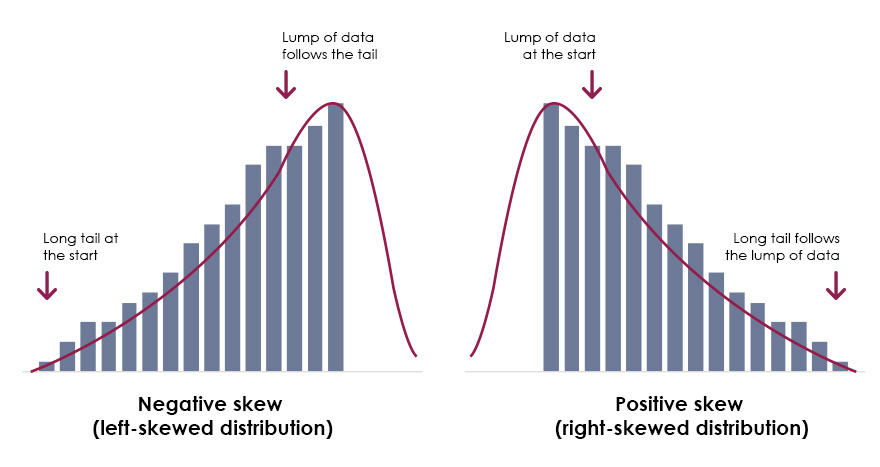

In [20]:
train_df.skew()

## Fix skewed features

In [33]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train_df.columns:
    if train_df[i].dtype in numeric_dtypes:
        numeric.append(i)

In [34]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data= train_df[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)


In [37]:
# Find skewed numerical features
skew_features = train_df[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

We use the scipy function boxcox1p which computes the Box-Cox transformation. The goal is to find a simple transformation that lets us normalize data.


The Box-Cox transformation transforms our data so that it closely resembles a normal distribution. In many statistical techniques, we assume that the errors are normally distributed. This assumption allows us to construct confidence intervals and conduct hypothesis tests

SciPy's stats package provides a function called boxcox for performing box-cox power transformation that takes in original non-normal data as input and returns fitted data along with the lambda value that was used to fit the non-normal distribution to normal distribution.

[Box cox transformation](https://www.geeksforgeeks.org/box-cox-transformation-using-python/)

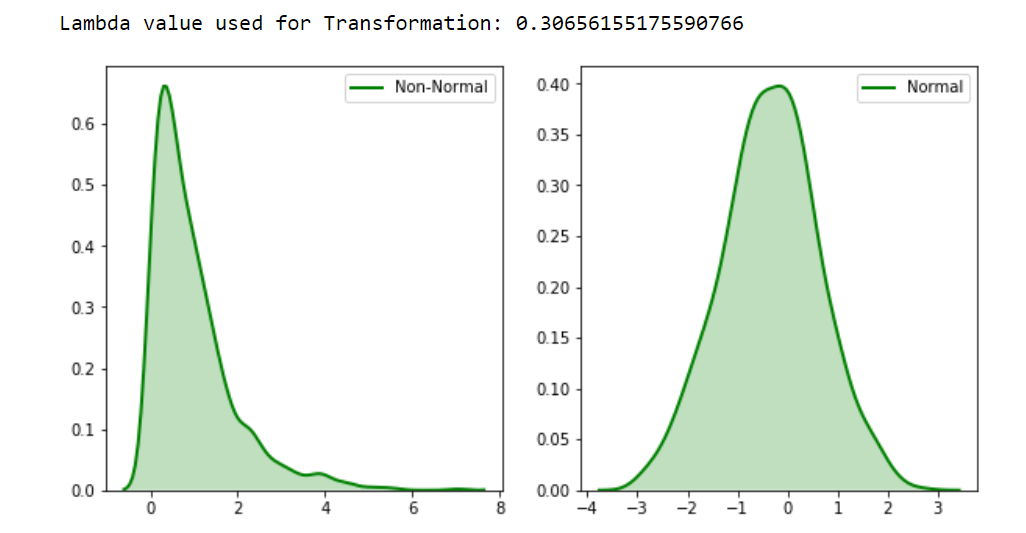

In [38]:
# Normalize skewed features
all_features = train_df.copy()
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

In [39]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

All the features look fairly normally distributed now.



In [40]:
all_features.head()

In [41]:
all_features.shape

In [42]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]

In [50]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in X.columns:
    if X[i].dtype in numeric_dtypes:
        if i in ['Unnamed: 0']:
            pass
        else:
            numeric.append(i)     
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, figsize=(12, 150))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(X[numeric]), 1):

    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='Y', hue='Y', palette='Blues', data=train_df)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('Y', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()


Let's define variables for preditive models

In [58]:
## Metrics for RandomforestClassifer
num_estimators=100
n_jobs=4
rfc_metric ='gini'

## Dataset spliting metrics
test_size = valid_size = 0.20
n_kfolds = 5
random_state = 42
verbose_eval = 50
early_stop = 50
max_rounds = 100
opt_rounds = 100



## Split data in train, test and validation set

Let's define train, validation and test sets.

In [65]:

data = all_features.drop(['Unnamed: 0'],axis=1).copy()

train_df, test_df = train_test_split(data, test_size=test_size, random_state=random_state, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=valid_size, random_state=random_state, shuffle=True )

target = 'Y'
predictors = list(data.drop('Y', axis=1).columns)


# Predictive models

Let's start with a RandomForrestClassifier model. We run this model using training set for training model and validation set for model validation.

>        1. The model validation criterion is **GINI** . Gini coefficient is a measure of how each variable contributes to the homogeneity of the nodes and leaves in the resulting random forest.
>        2. It is sometimes called “gini importance” or “mean decrease impurity” and is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.
>        3. A Gini coefficient of zero means there is an equal distribution of 'Target variable', whereas a number closer to one indicates greater inequality. The lower the Gini coefficient, the more equal the society is said to be.

In [68]:
clf = RandomForestClassifier(n_jobs=n_jobs, 
                             random_state=random_state,
                             criterion=rfc_metric,
                             n_estimators=num_estimators,
                             verbose=False)

clf.fit(train_df[predictors], train_df[target].values)
preds = clf.predict(valid_df[predictors])


## Features importance


In [70]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (15,15))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

The most important features are **X52, X53, X7, X16, X55**.



## Confusion matrix 



In [71]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Class0', 'Class1'],
            yticklabels=['Class0', 'Class1'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

## Type I error and Type II error

Confussion matrix isn't very good to represent results of unbalanced dataset. We might need different metrics that can give importance  to selectivity and specificity. We would like to  minimize Type I errors and Type II errors.

Null Hypothesis (H0) - The Records belong to Label0.
Alternative Hypothesis (H1) - The Records belong to Label1.

Type I error - You reject the null hypothesis when the null hypothesis is actually true.
Type II error - You fail to reject the null hypothesis when the the alternative hypothesis is true.

The following image explains what Type I error and Type II error are:

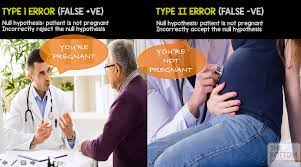

Let's checkout the ROC-AUC score

## Area under curve


In [74]:
roc_auc_score(valid_df[target].values, preds)

The ROC-AUC score for randomforestClassifier is 94%

## Light GBM

Let's continue with other tree based gradient boosting algorithm

In [79]:
# Let's define the model parameters

params = {
    'max_depth': 4,
    'nthread': 8,
    'verbose': 0,
    'min_child_samples': 100,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric':'auc',
    'learning_rate': 0.05,
    'subsample_freq': 1,
    'max_bin': 100,
    'subsample': 0.9,
    'scale_pos_weight':150
    
}

# Let's prepare the train, valid datasets

dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

# let's run the model

evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=max_rounds,
                  early_stopping_rounds=2*early_stop,
                  verbose_eval=verbose_eval, 
                  feval=None)

**Light GBM obtained best train auc score: 98% , AUC =~ 0.97**



#### Variable importance plot

In [80]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

Predict and calculate the ROC-AUC score for prediction

In [81]:
preds = model.predict(test_df[predictors])

roc_auc_score(test_df[target].values, preds)

The ROC-AUC score obtained for the test set is 0.97.



# Training and validation using cross-validation

We will use cross-validation (KFolds) with 5 folds. Data is divided in 5 folds and, by rotation, we are training using 4 folds (n-1) and validate using the 5th (nth) fold.

Test set is calculated as an average of the predictions

In [90]:
kf = KFold(n_splits = n_kfolds, random_state = random_state, shuffle = True)


oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0

for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx],train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx],train_df[target].iloc[valid_idx]
    
    evals_results = {}
    model =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  verbose=-1,
                  feval=None)
    
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= verbose_eval, early_stopping_rounds= early_stop)
    
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1
train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)

The AUC score for prediction from test data was 0.94


The final test prediction is the averaged prediction. Thy were taken from testing over 5 folds.

In [92]:
pred = test_preds

# Conclusion

* The data was explored, checked for data imbalances, features were visualized to understand feature relations. We then saw 2 predictive models. The data was split into 3 sets ( Train set, validation set and test set).

* We started with **RandomForestClassifier**, for which we obtained **AUC score** of **0.94** 

* We then presented the data to **LightGBM Model**. We used train-validation split and cross-validation with 5 folds , to evaluate the model effectiveness to predict 'Class' value, ie: Detect if record belongs to label 0 or label 1.  
   - For train-validation set we received AUC score 0.98 
   - For test set, the score obtained was 0.97. 
   - With the cross-validation, the test auc score obtained was 0.94.

# References

1. [Cross-validation in ML](https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right)
2. [LightGBM Python implementation](https://github.com/Microsoft/LightGBM/tree/master/python-package)
3. [LightGBM algorithm](https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf)